# Test the buttons

We need to figure out which of the inputs do what.
(Start is block by the way)

In [2]:
import numpy as np
import pandas as pd
import gymnasium as gym
import retro
import matplotlib.pyplot as plt
import subprocess
import os
from itertools import product


In [3]:
env = retro.make(game='MortalKombatII-Genesis', render_mode='rgb-array',
                 players = 2, state = 'SubZero_Jax_2P')


In [5]:
# iterate forward n frames until the environment is responsive to user inputs
# the number needed has to do with which frame the save state was created on
def fastforward(env, n_frames):
    _ = env.reset()
    for i in range(n_frames):
       a = np.zeros(env.action_space.n)
       obs = env.step(a)
    img = obs[0]
    return img

def get_button_result(env, which_button, hold_for = 3, repeat = True):
    a = np.zeros(env.action_space.n)
    a[which_button] = 1
    for i in np.arange(hold_for):
        if not repeat:
            a = np.zeros(env.action_space.n)
        obs = env.step(a)
    img = obs[0]
    return img

def check_all_buttons(env, frame_delay, hold_for = 3, repeat = True):
    frame_list = []
    for i in range(env.action_space.n):
        fastforward(env, frame_delay)
        img = get_button_result(env = env, which_button = i, hold_for = hold_for, repeat = repeat)
        frame_list = frame_list + [img] 
    
    return frame_list

In [6]:

## need 122 frames for THIS state
starting_point = fastforward(env, 122)


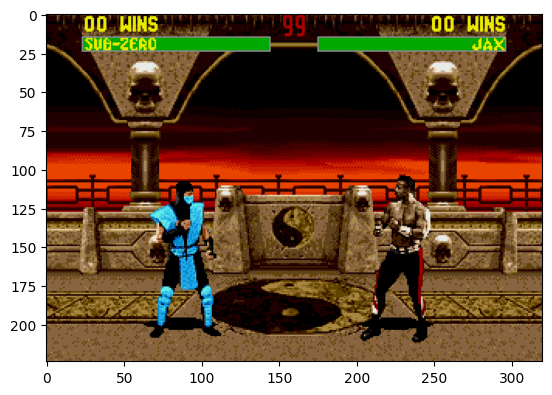

In [7]:
plt.imshow(starting_point)

In [13]:
env.action_space.n

24

In [8]:
button_results = check_all_buttons(env, frame_delay=122, hold_for = 10)

In [42]:
#plot_buttons(button_results)

In [40]:
relevant_buttons_p1 = np.array([0, 1, 3, 4, 5, 6, 7, 8])
relevant_buttons_p2 = relevant_buttons_p1 + 12
print(relevant_buttons_p1)
print(relevant_buttons_p2)

[0, 1, 3, 4, 5, 6, 7, 8]
[12 13 15 16 17 18 19 20]


In [11]:
def plot_spec_buttons(button_set, img_list, fig_title):

    n_buttons = len(button_set)

    fig, axes = plt.subplots(3, 4, figsize=(12,8))

    for ax, button in zip(axes.flat, button_set):
        #print(type(ax))
        ax.imshow(img_list[button])
        ax.set_title(f'Button {button}')
        
    fig.suptitle(fig_title)
    plt.tight_layout()
    plt.show()



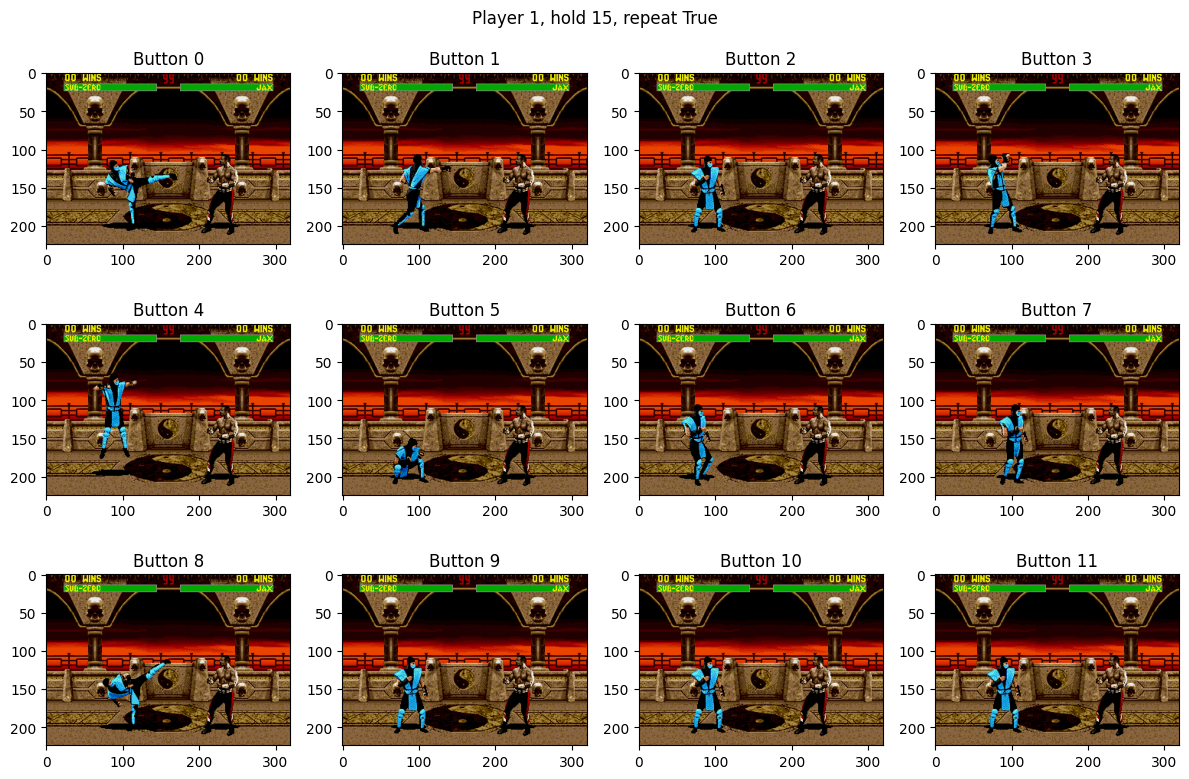

In [12]:
#plot_spec_buttons(relevant_buttons_p1, button_results, 'Player 1, hold for 15 steps')
#plot_spec_buttons(relevant_buttons_p2, button_results, 'Player 2, hold for 15 steps')
plot_spec_buttons(range(12), button_results, 'Player 1, hold 15, repeat True')

In [17]:



holds = [5,10,15,20]
repeat = [True, False]

spec_df = pd.DataFrame(list(product(holds, repeat)),
                       columns = ['hold_for', 'repeat'])
spec_df



hold_for  repeat
0         5    True
1         5   False
2        10    True
3        10   False
4        15    True
5        15   False
6        20    True
7        20   False

In [71]:

master_img_list = []

for idx, row in spec_df.iterrows():
    spec_results = check_all_buttons(env = env, frame_delay = 124, hold_for = row['hold_for'], repeat = row['repeat'])
    master_img_list = master_img_list + [spec_results]

spec_df['image_list'] = master_img_list

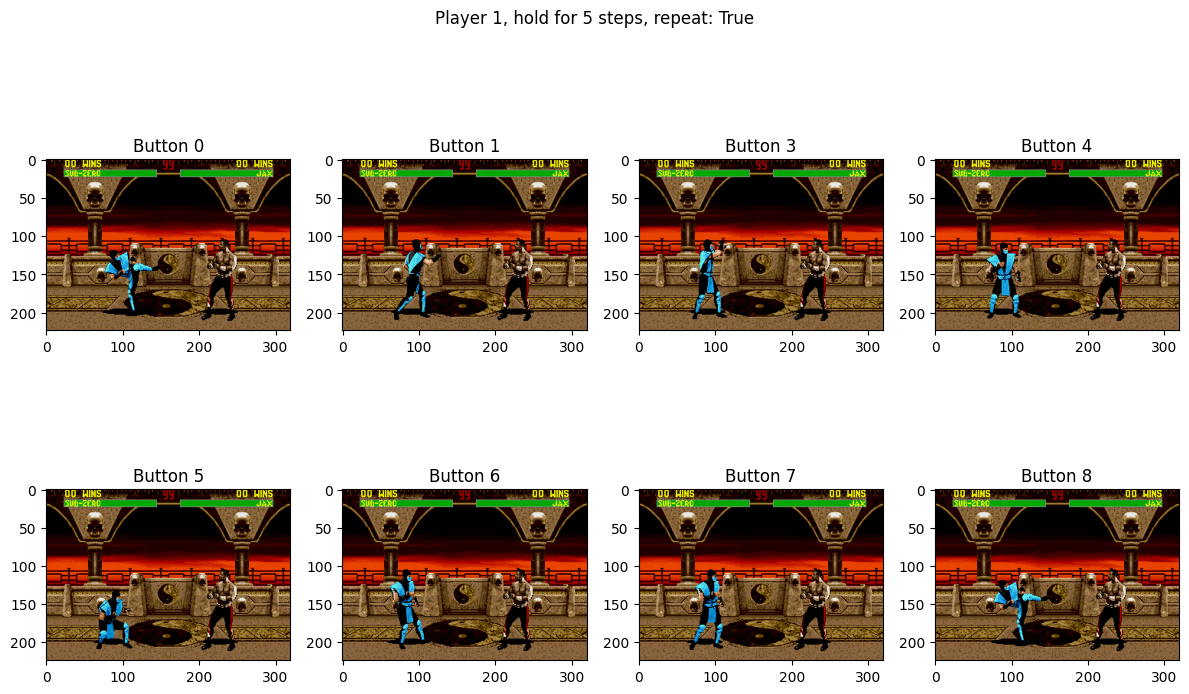

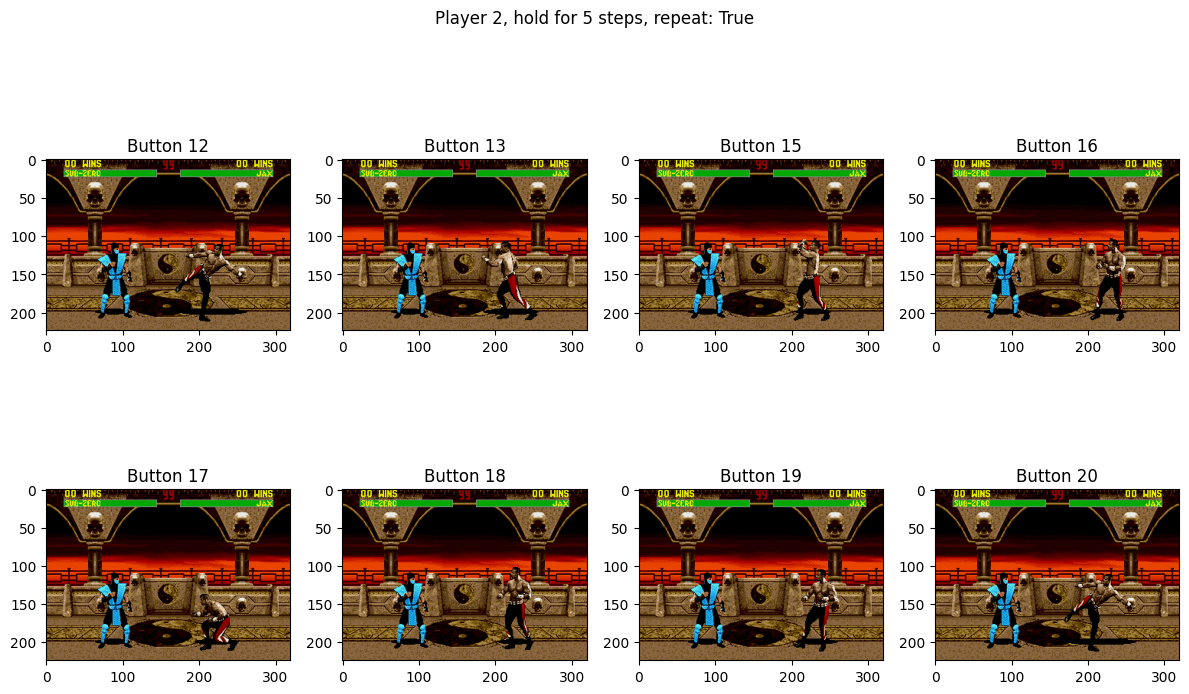

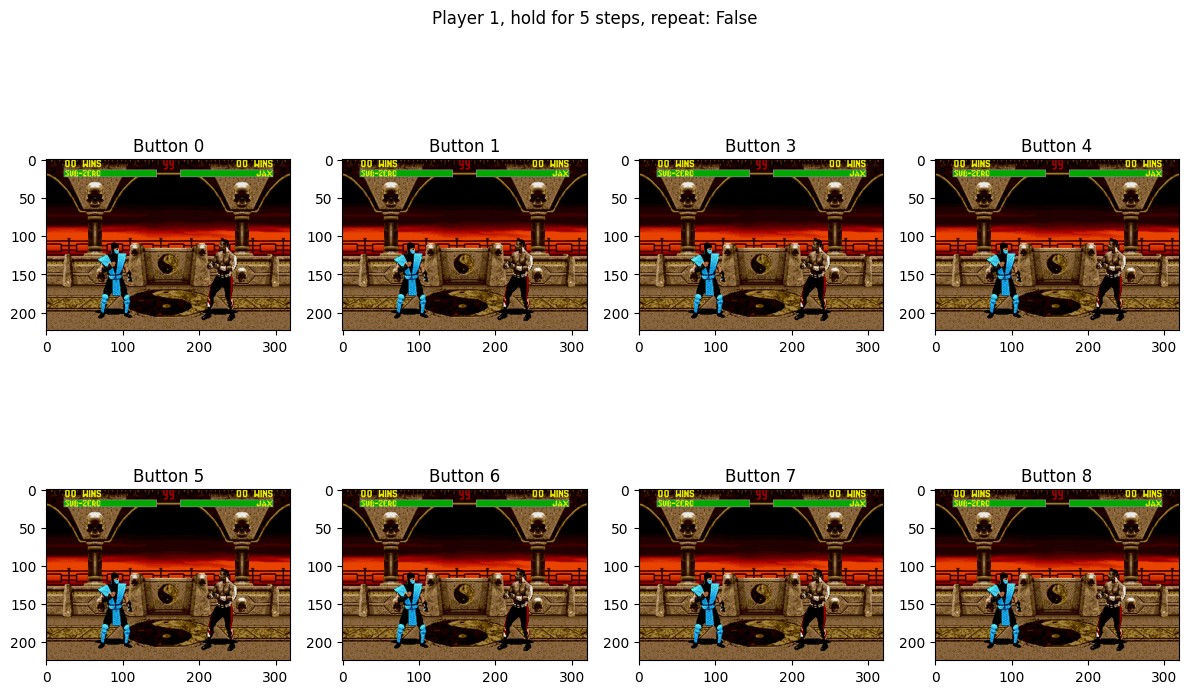

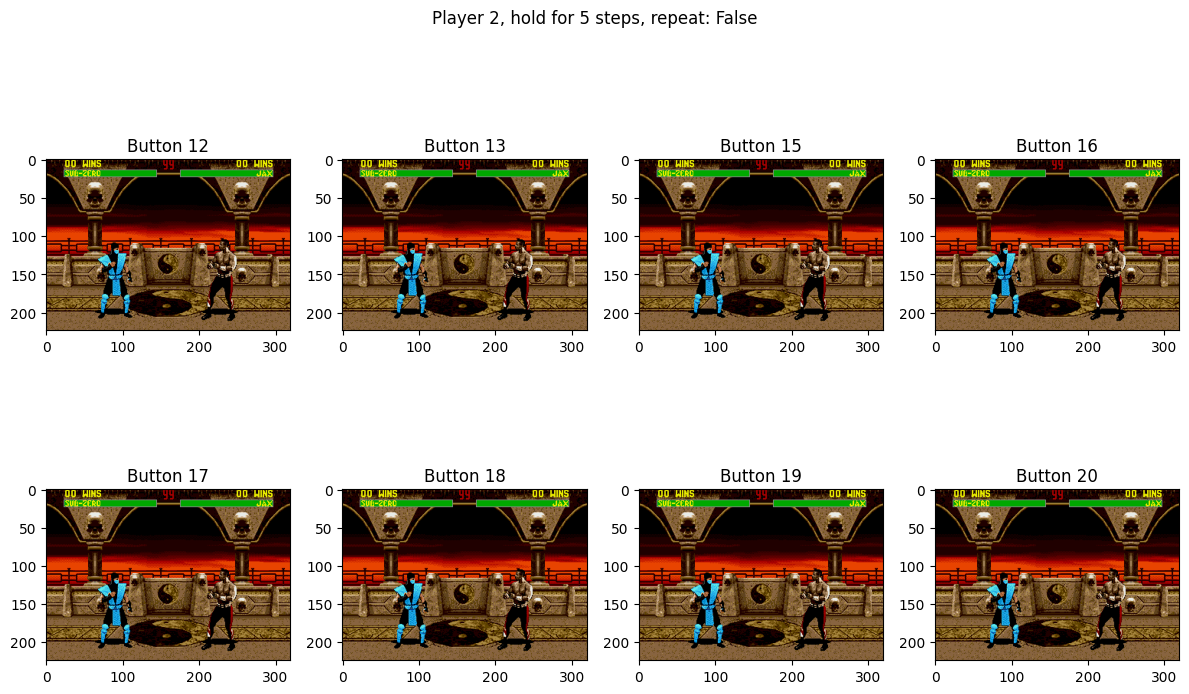

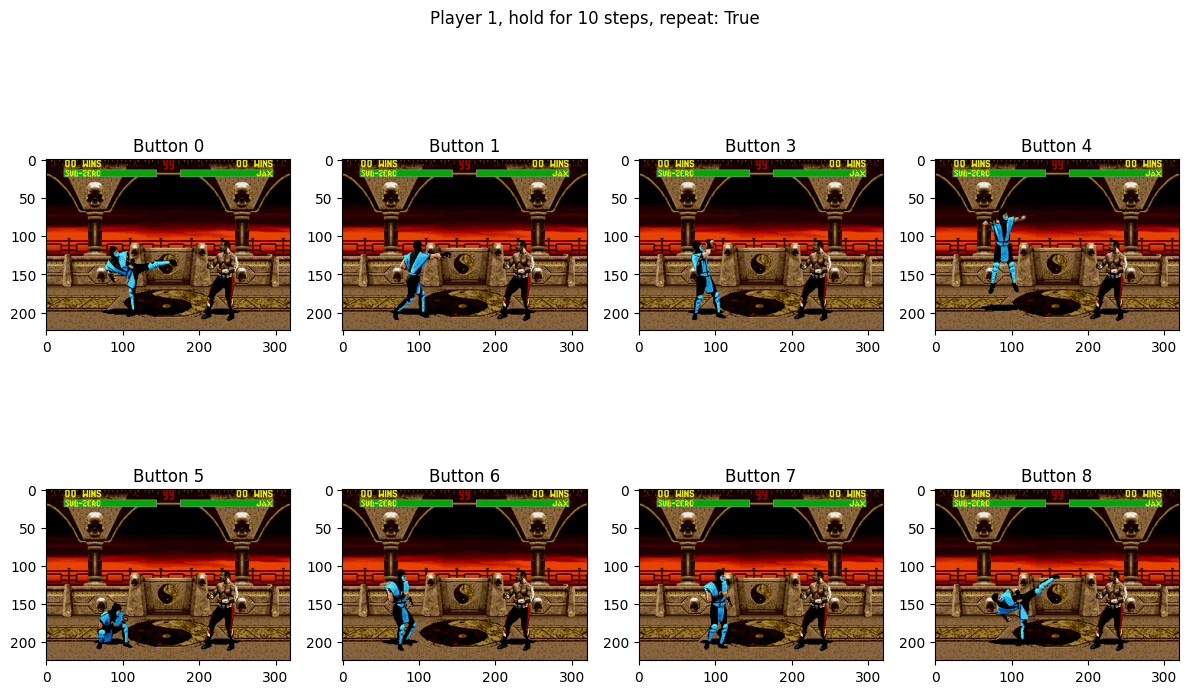

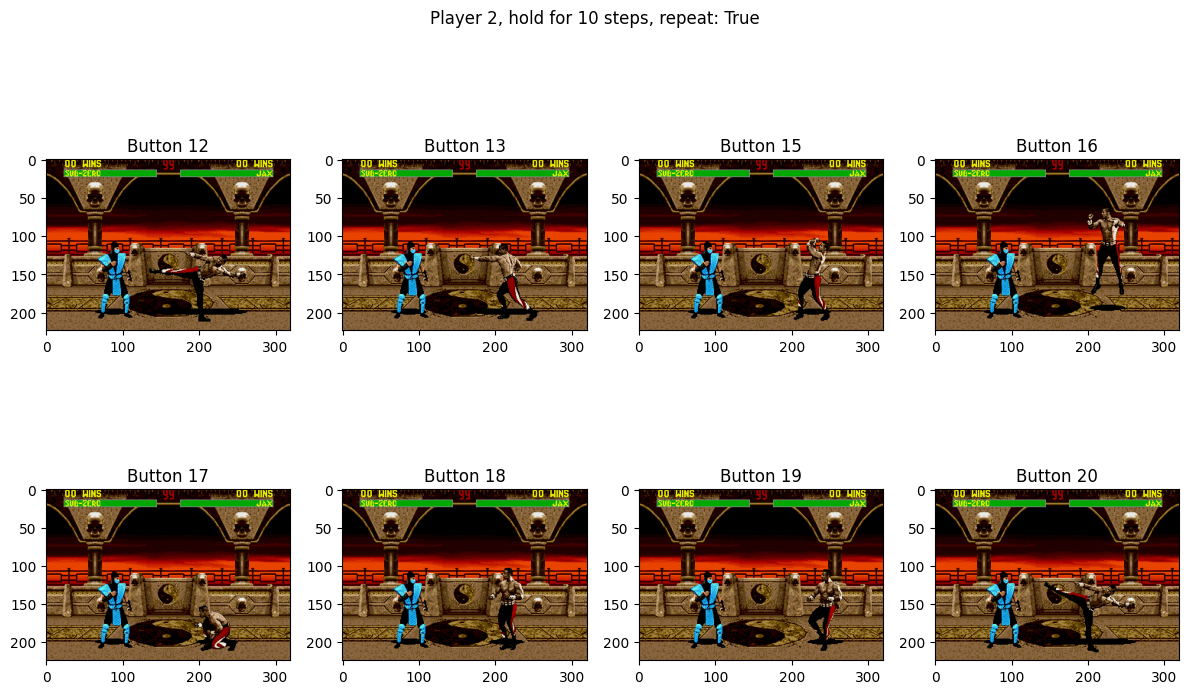

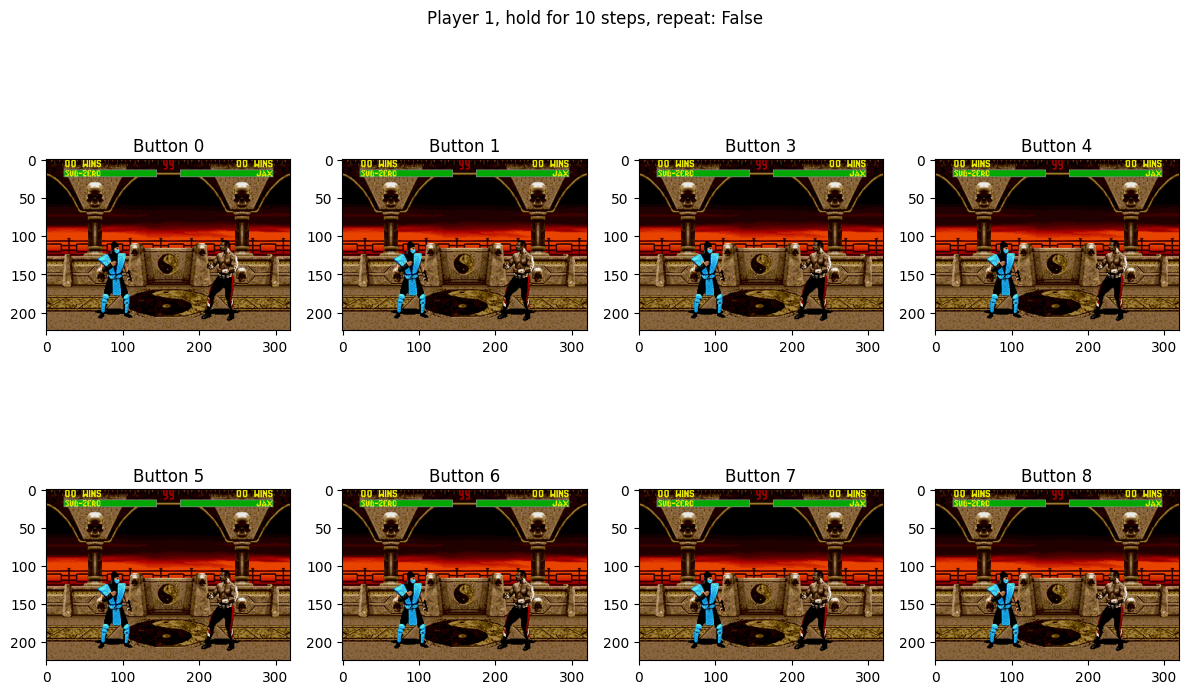

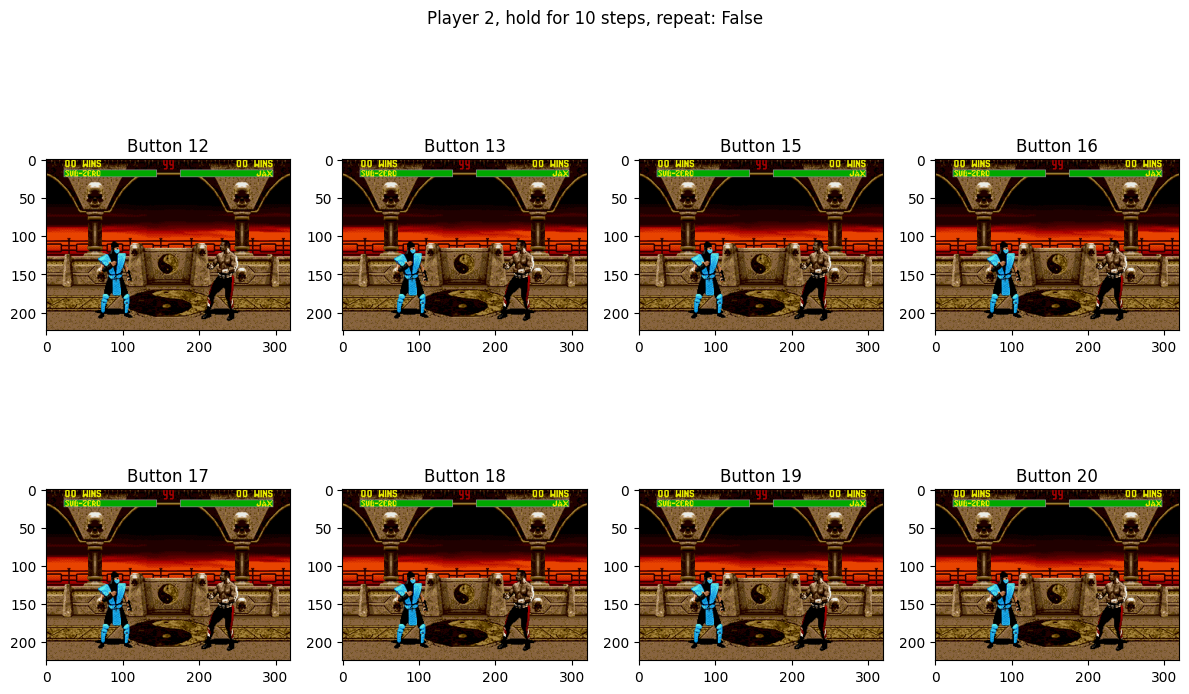

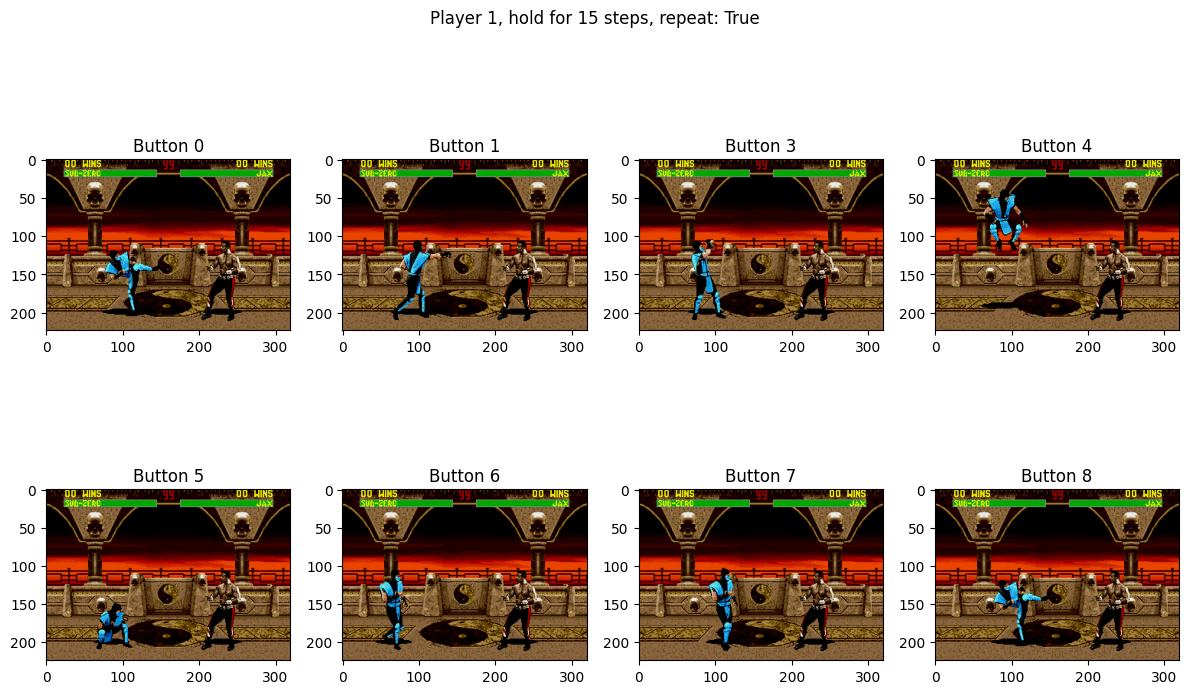

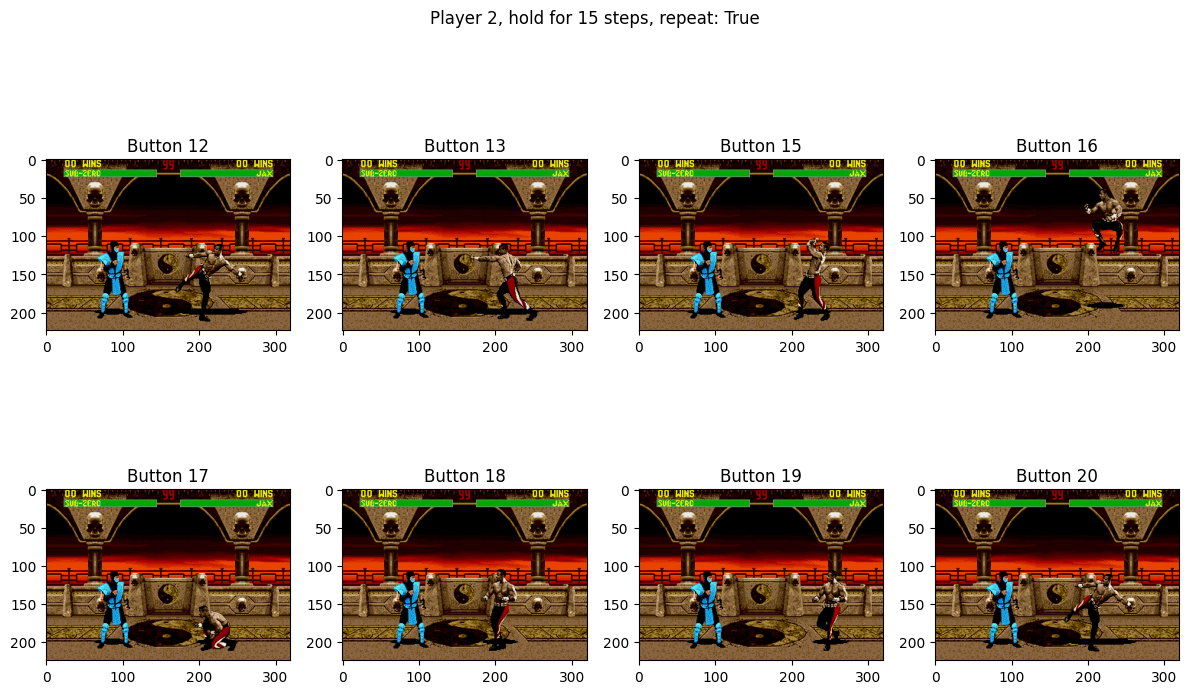

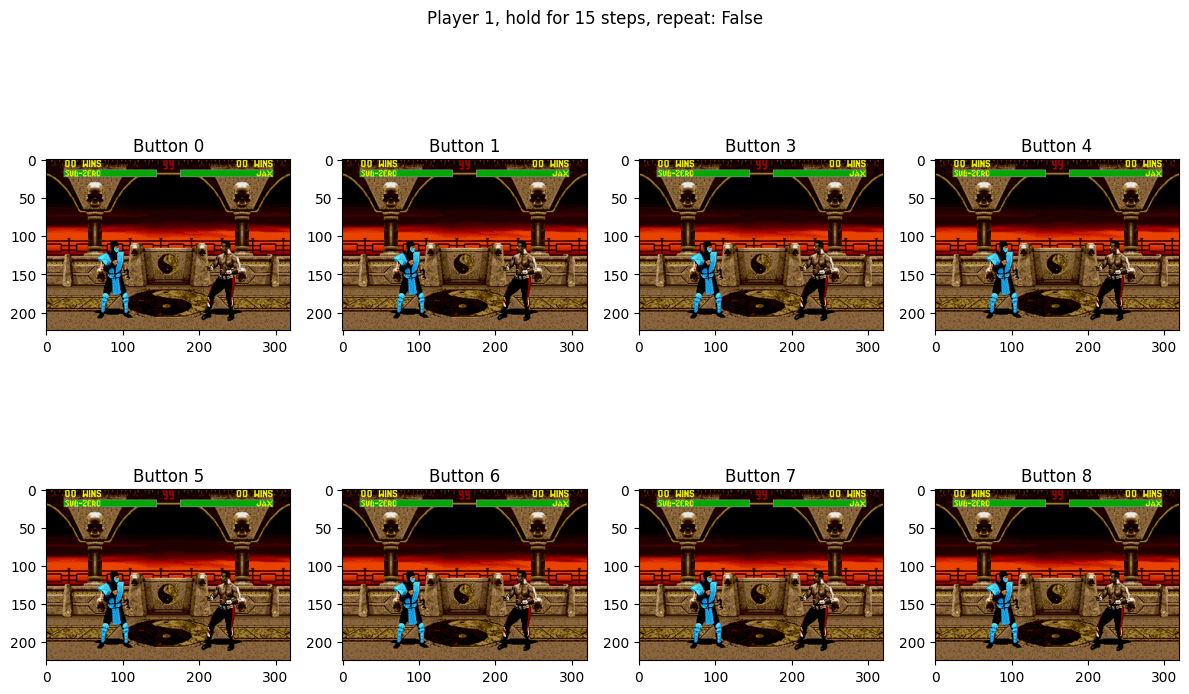

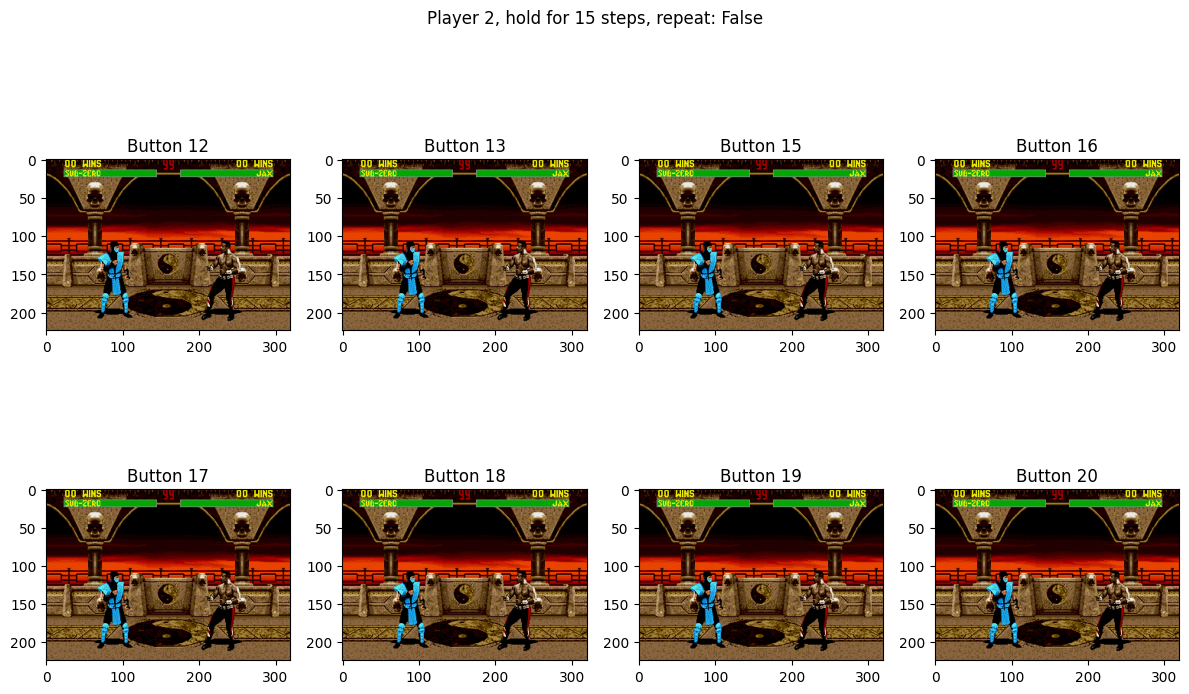

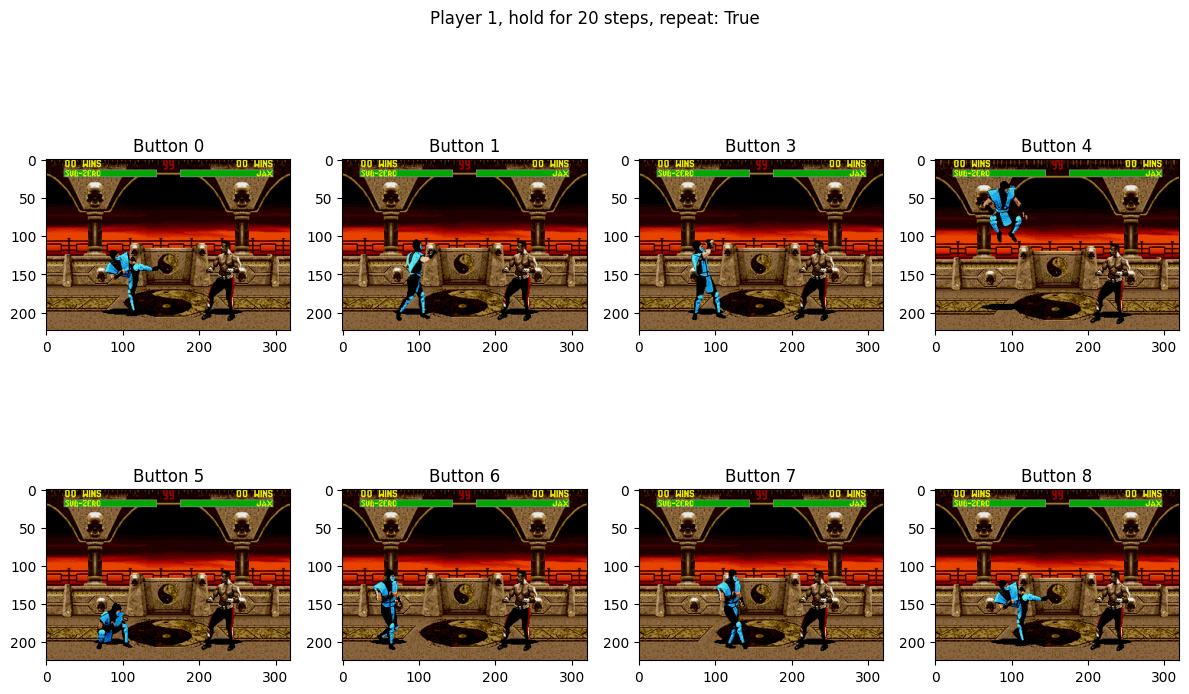

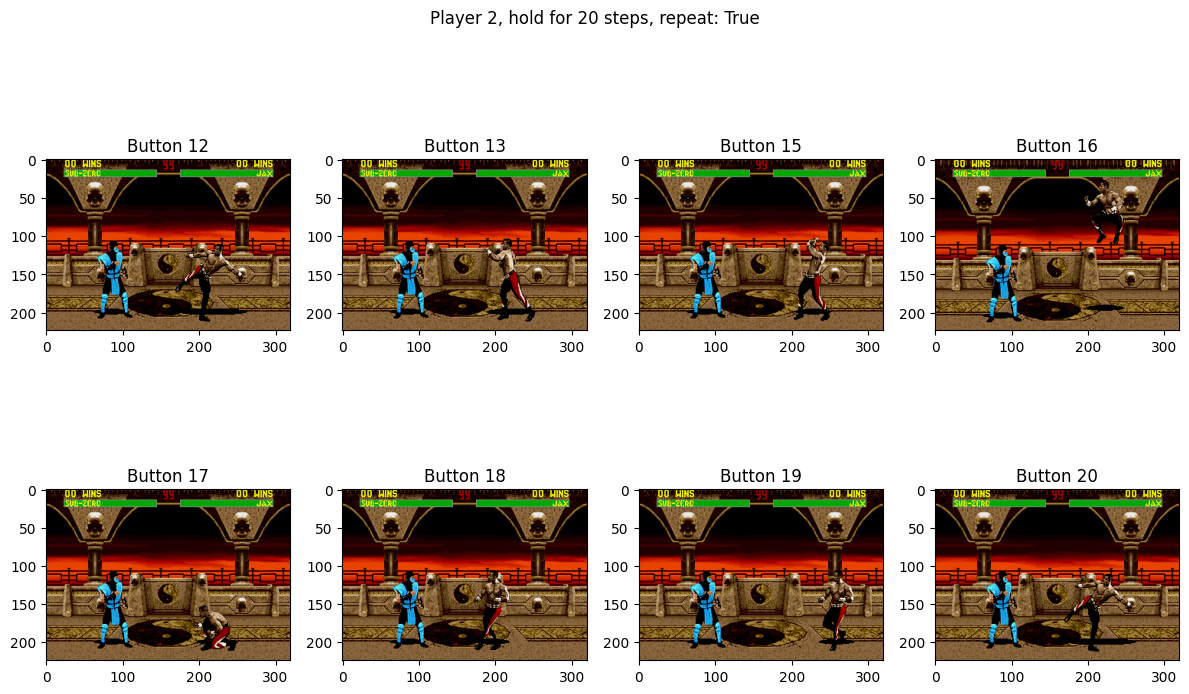

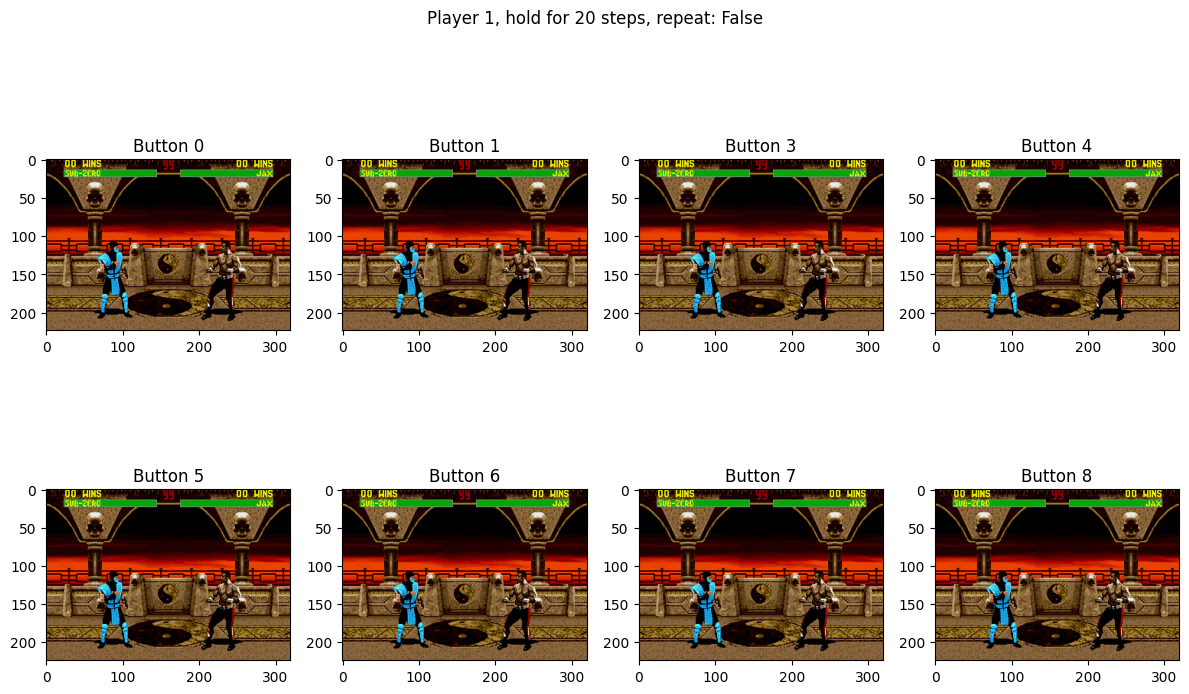

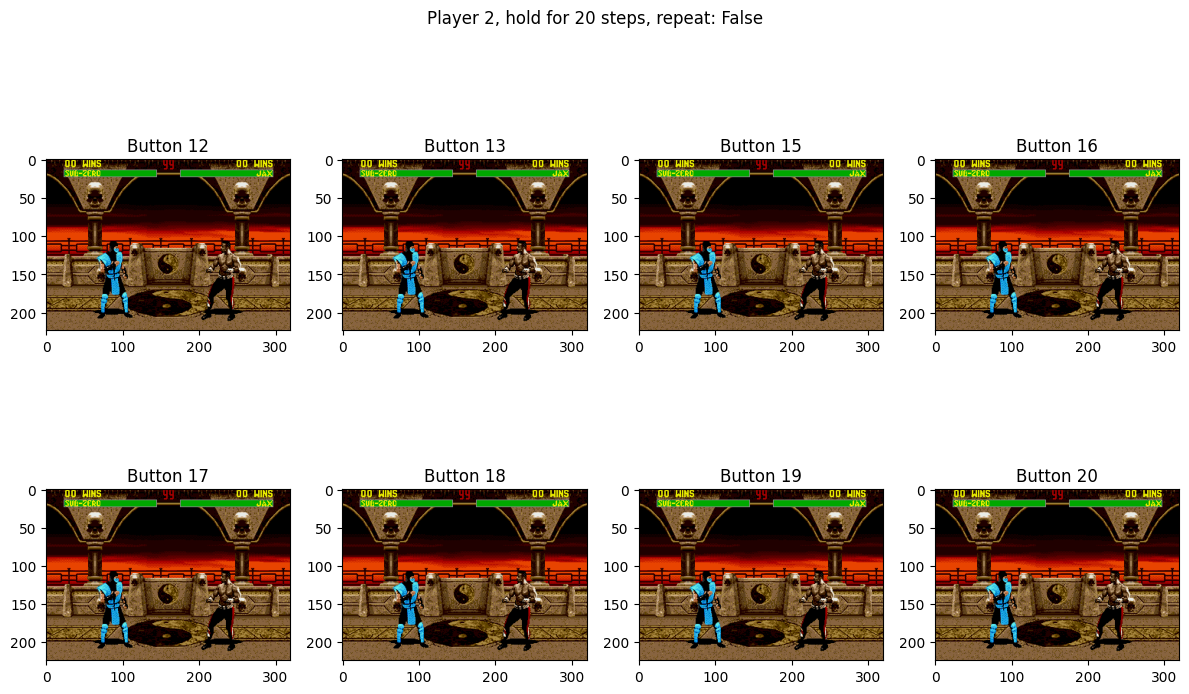

In [73]:

for idx, row in spec_df.iterrows():
    title1 = f'Player 1, hold for {row['hold_for']} steps, repeat: {row['repeat']}'
    title2 = f'Player 2, hold for {row['hold_for']} steps, repeat: {row['repeat']}'
    plot_spec_buttons(relevant_buttons_p1, row['image_list'], title1)
    plot_spec_buttons(relevant_buttons_p2, row['image_list'], title2)
    

convert to discrete action space (?)

per manual

from frame testing, relevant buttons are 

[0, 1, 3, 4, 5, 6, 7, 8]

identify button mapping based on the genesis manual: [https://www.manua.ls/sega/mortal-kombat-ii/manual?p=8]

down: button 5
up: button 4

A: button 1
B: button 0
C: button 8

start: button 3
left: button 6
right: button 7



moves are: None, U, D, L, R + Start + [A or B or C] * [none, U, D, L, R]

6 + 15 = 21
Discrete(21) action space


In [13]:
disc = gym.spaces.Discrete(21)

In [27]:
disc.sample()

np.int64(0)

In [16]:
button_mapping = {'start':3,
                  'up':4,
                  'down':5,
                  'left':6,
                  'right':7,
                  'A':1,
                  'B':0,
                  'C':8}

In [22]:
multi_inputs = product(['A','B','C'],['up','down','left','right'])
moves = [[button_mapping[b1], button_mapping[b2]] for b1,b2 in multi_inputs]


In [23]:
moves

[[1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [8, 4],
 [8, 5],
 [8, 6],
 [8, 7]]

In [33]:
moveset = moves + [[item] for item in button_mapping.values()] + [[]]

In [34]:
action_dict = dict()

for i, m in enumerate(moveset):
    action_dict[i] = m

In [35]:
action_dict

{0: [1, 4],
 1: [1, 5],
 2: [1, 6],
 3: [1, 7],
 4: [0, 4],
 5: [0, 5],
 6: [0, 6],
 7: [0, 7],
 8: [8, 4],
 9: [8, 5],
 10: [8, 6],
 11: [8, 7],
 12: [3],
 13: [4],
 14: [5],
 15: [6],
 16: [7],
 17: [1],
 18: [0],
 19: [8],
 20: []}

In [38]:
def convert_action_to_move(discrete_action):
    button_idxs = action_dict[discrete_action]
    new_action = np.zeros(12)
    for bi in button_idxs:
        new_action[bi] = 1
    return new_action

In [39]:
for i in range(5):
    da = disc.sample()
    act = convert_action_to_move(da)
    print(da)
    print(act)

15
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
6
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
20
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
14
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
5
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
